### 神经网络 sigmoid 函数 逻辑回归

sigmoid 函数定义域 (负无穷、正无穷)，值域 (0, 1)

> 最大概似法：
比方统计一枚不太规则的硬币那一面出现的概率更大，将每次抛硬币都看作独立的事件，相互不受影响，则每次抛硬币大自然都会给出概率尽可能高的结果，将每次抛出的样本结果出现的概率累计，应该趋向最大

> 交叉熵：
利用最大概似法得到的损失函数，称为交叉熵

In [1]:
import torch
import numpy as np
from sklearn import metrics
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
cluster = torch.ones(500,2)

In [3]:
# 4 和 -4 为期望值、2为标准差，生成两批随机数据，共 1000 个数据样本
data0 = torch.normal(4*cluster, 2)
data1 = torch.normal(-4*cluster, 2)

In [4]:
# 生成 0、1 标签
label0 = torch.zeros(500)
label1 = torch.ones(500)

In [5]:
# 合并 data
x = torch.cat((data0,data1)).type(torch.FloatTensor)

In [6]:
# 合并 label,并扩展 第一维
label = torch.cat((label0,label1))
label = torch.unsqueeze(label,dim=1)

In [7]:
# data 和 label 在第一维合并
x = torch.cat((x,label), dim=1)
# 洗牌
np.random.shuffle(x.numpy())

In [8]:
# x.numpy()[:,2] ，合并后的 label 列
y = torch.tensor(x.numpy()[:,2]).type(torch.LongTensor)

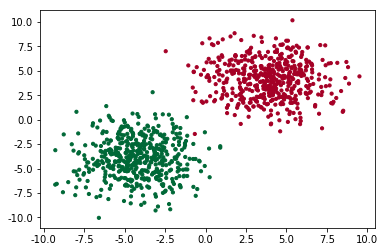

In [9]:
plt.scatter(x.numpy()[:,0], x.numpy()[:,1], c=y.numpy(), s=10, cmap='RdYlGn')

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 输入是两个特征，横轴和纵轴，输出的是两个类的 "得分" 情况，假设哪类 “分数” 高，就属于那一类
        self.linear = nn.Linear(2,2)
        
    def forward(self, x):
        x = self.linear(x)
        # sigmoid 生成两个类的概率，“分数” 高的类所得到的概率就高，且两个类的概率之和为 1
        x = torch.sigmoid(x)
        return x

In [11]:
inputs = torch.tensor(x.numpy()[:,0:2])
target = y
model = Net()

In [12]:
a = torch.randn(4, 4)
a

tensor([[ 0.0151, -0.2381,  0.1086, -0.5399],
        [-1.2665,  0.5433, -0.0977, -1.2548],
        [-0.5171, -1.7942, -0.2234,  1.0513],
        [ 0.5449, -0.3607, -0.0690,  0.9510]])

In [13]:
b = torch.sigmoid(a)
b

tensor([[0.5038, 0.4408, 0.5271, 0.3682],
        [0.2199, 0.6326, 0.4756, 0.2219],
        [0.3735, 0.1426, 0.4444, 0.7410],
        [0.6330, 0.4108, 0.4828, 0.7213]])

In [14]:
# dim=1，取出列值最大的
torch.max(b, dim=1)

torch.return_types.max(
values=tensor([0.5271, 0.6326, 0.7410, 0.7213]),
indices=tensor([2, 1, 3, 3]))

In [15]:
def train(inputs, target, model, epochs, lr=0.02):
    # 定义 交叉熵 损失函数
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    output = None
    for epoch in range(epochs):
        # 输出分成两个 类别 各自的 概率
        output = model(inputs)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            draw(inputs, target, output)
    return model, loss, output

def draw(inputs, target, output):
    plt.cla()
    # 取出概率最大的类别标签
    output = torch.max((output), 1)[1]
    pred_y = output.numpy()
    target_y = target.numpy()
    # 用预测画图
    plt.scatter(inputs.numpy()[:,0], inputs.numpy()[:,1], c=pred_y, s=10, cmap='RdYlGn')
    # 求预测精确度
    accuracy = sum(pred_y == target_y) / pred_y.size
    plt.text(1.5, -4, 'Accuracy=%s' % (accuracy), fontdict={'size':20, 'color':'red'})
    plt.pause(0.05)

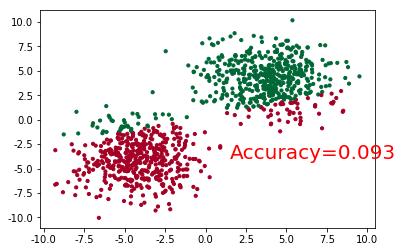

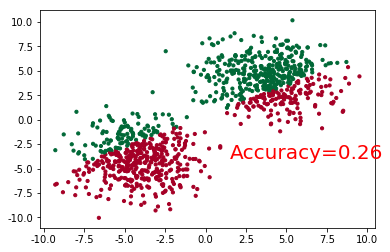

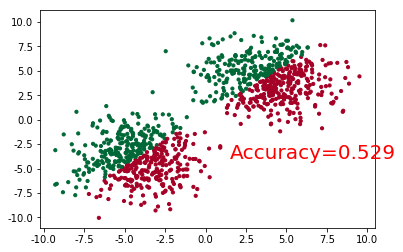

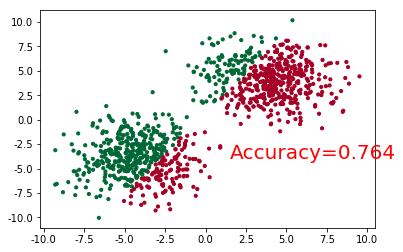

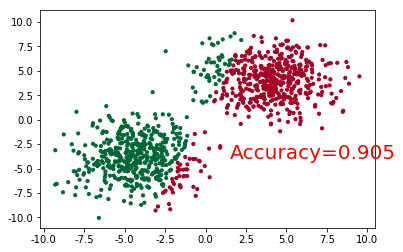

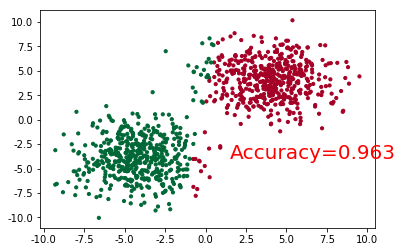

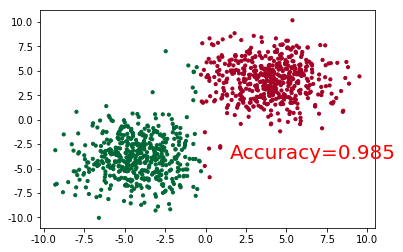

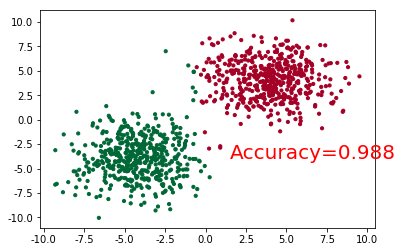

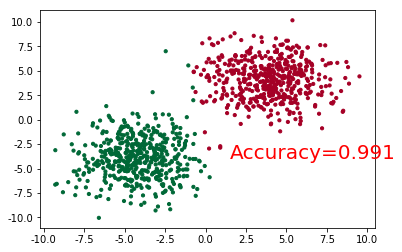

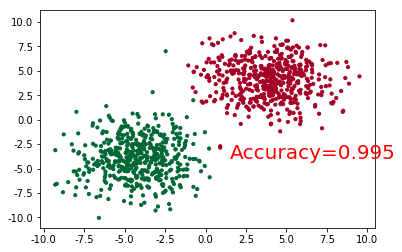

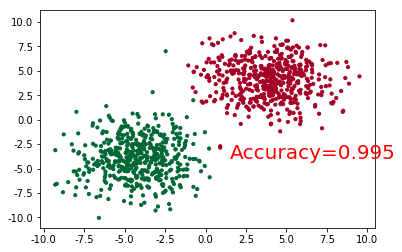

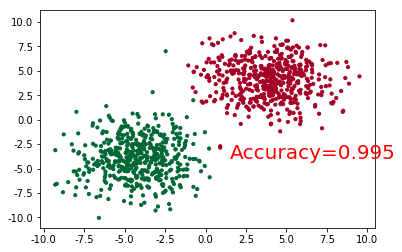

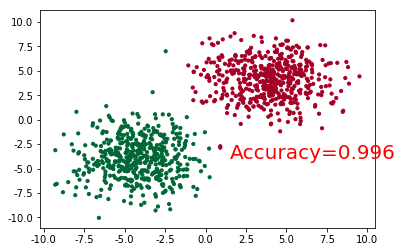

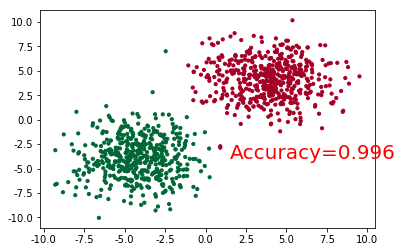

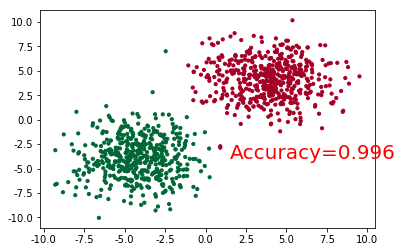

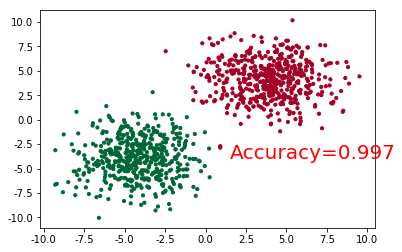

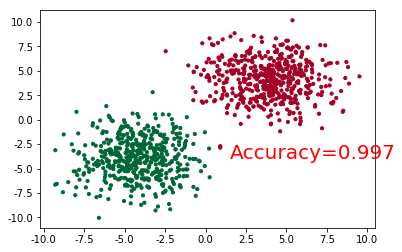

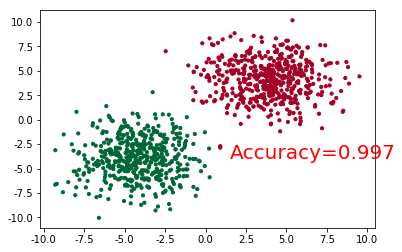

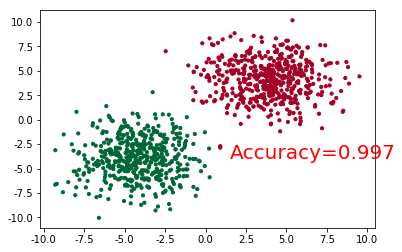

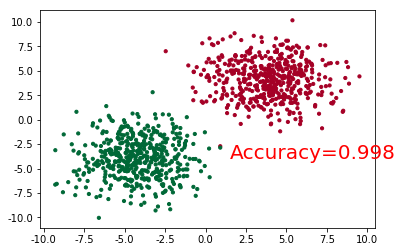

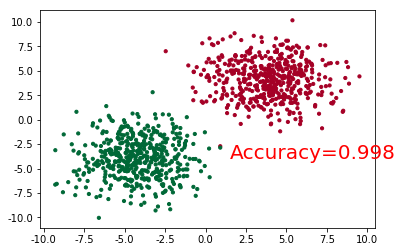

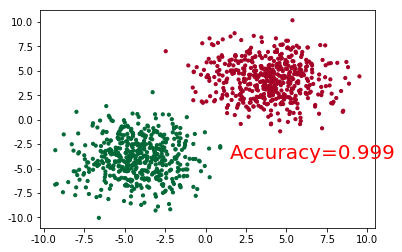

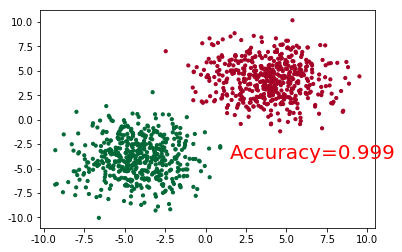

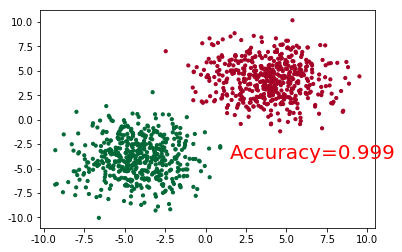

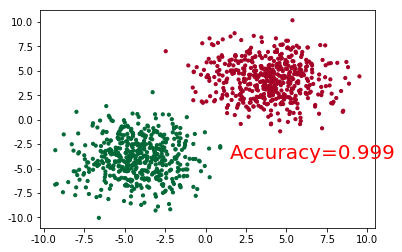

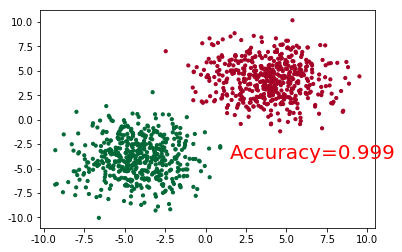

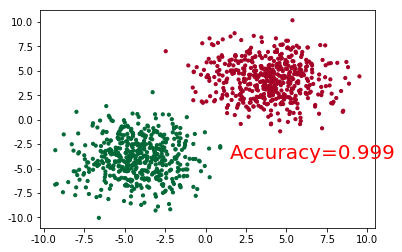

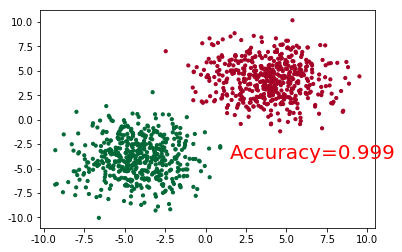

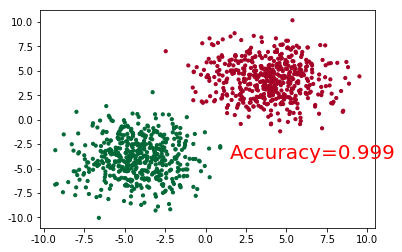

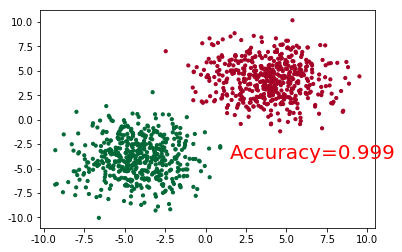

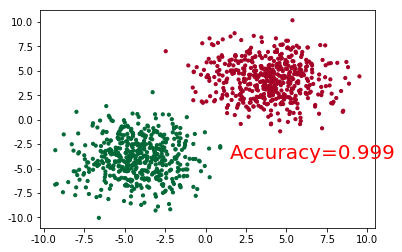

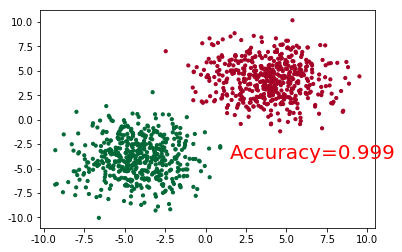

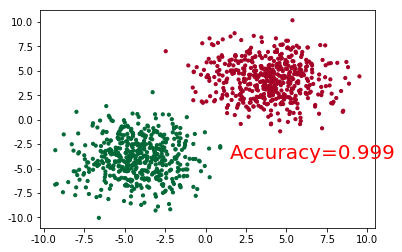

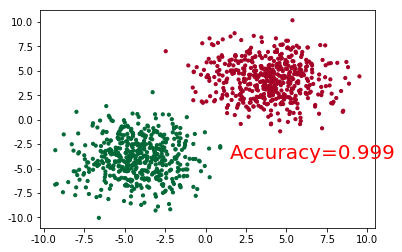

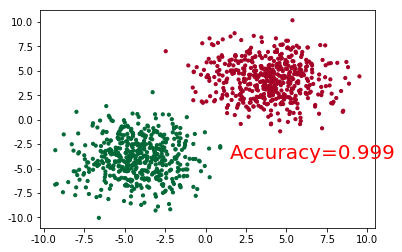

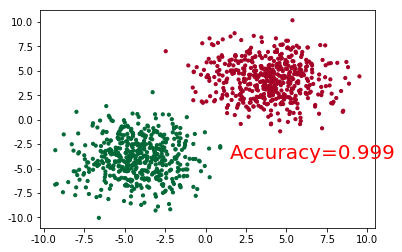

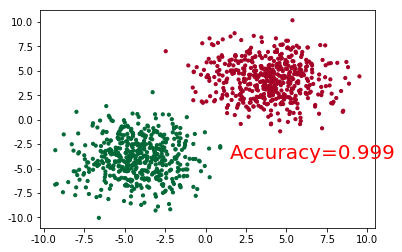

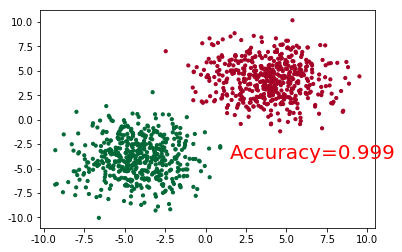

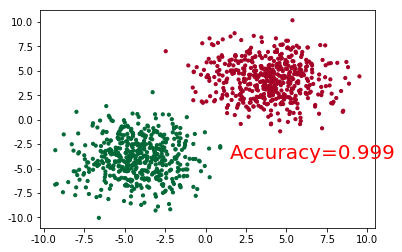

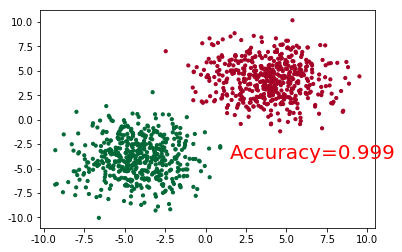

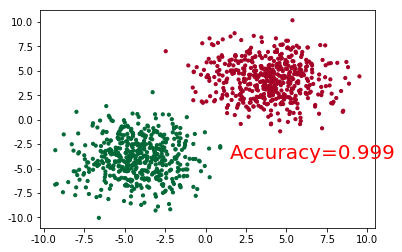

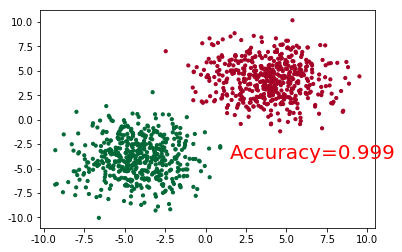

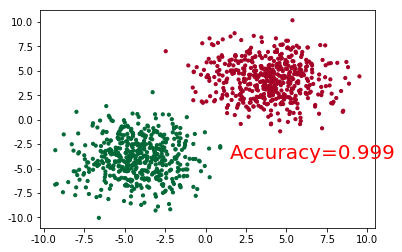

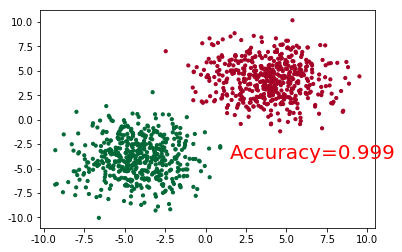

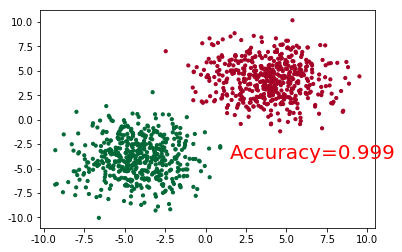

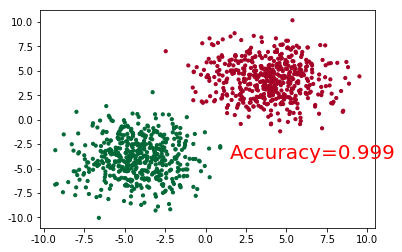

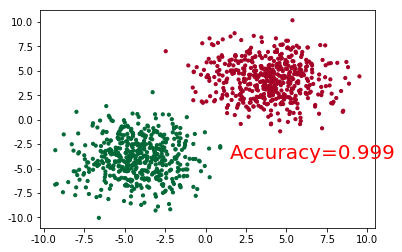

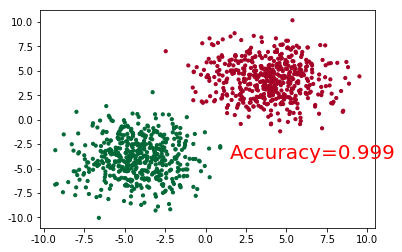

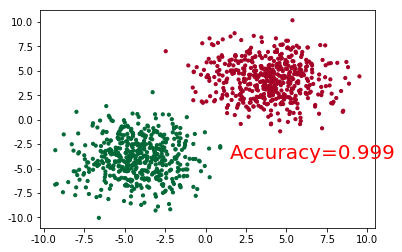

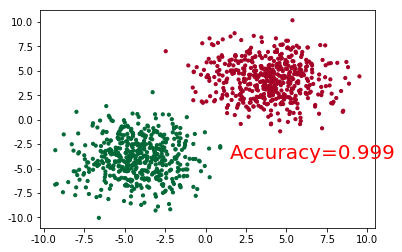

In [16]:
model, loss, output = train(inputs, target, model, 1000)

In [17]:
def test_model(inputs, test_target, model):
    output = model(inputs)
    output = torch.max((output), 1)[1]
    pred_y = output.numpy()
    target_y = target.numpy()
    accuracy = sum(pred_y == target_y) / pred_y.size
    print('Accuracy=%s' % (accuracy))
    return target_y, pred_y

In [18]:
target_y, pred_y = test_model(inputs, target, model)

Accuracy=0.999


In [21]:
fpr, tpr, _ = metrics.roc_curve(target_y, pred_y)
print("模型AUC：%s" % metrics.auc(fpr, tpr))

模型AUC：0.999


In [20]:
def evaluation_torch(target, pred):
    '''
    计算预测结果的查准查全率以及f1
    参数
    ----
    re: Dataframe, 预测结果, 里面包含两列: 真实值 'label_code', 预测值 'pred'
    '''
    # 预测为 1，实际为 1
    tp = sum(pred * target)
    # 预测为 0，实际为 0
    tn = sum(np.logical_not(pred) * np.logical_not(target))
    # 预测为 1，实际为 0
    fp = sum(np.logical_xor(pred[np.nonzero(pred)], target[np.nonzero(pred)]))
    # 预测为 0，实际为 1
    fn = sum(np.logical_xor(pred[np.nonzero(np.logical_not(pred))], 
                            target[np.nonzero(np.logical_not(pred))]))
    presion = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = 2 * presion * recall / (presion + recall)
    print("数据中Y = 1的个数：%s" % sum(target))
    print("预测结果中Y = 1的个数：%s" % sum(pred))
    print('查准率: %3f, 查全率: %3f, f1: %3f' % (presion, recall, f1))

In [22]:
evaluation_torch(target_y, pred_y)

数据中Y = 1的个数：500
预测结果中Y = 1的个数：501
查准率: 0.998004, 查全率: 1.000000, f1: 0.999001
